[18945.21205228]


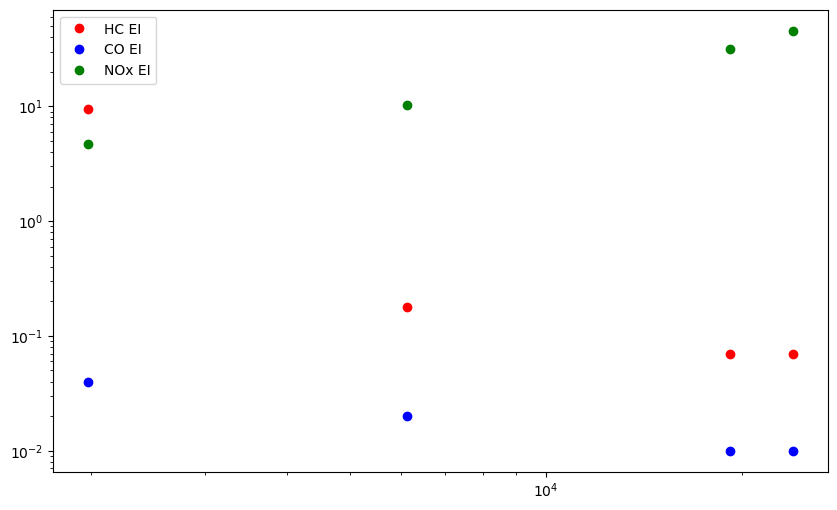

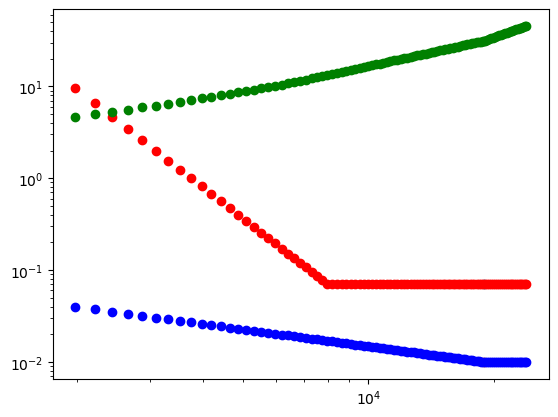

In [17]:
from ambiance import Atmosphere
import numpy as np
from pa_to_psi import pa_to_psi
from ft_to_m import ft_to_m
import matplotlib.pyplot as plt

fuel_flow_icao = np.array([2.989, 2.387, 0.755, 0.227]) # kg/s
HC_ei_vec = np.array([0.07, 0.07, 0.18, 9.53])
CO_ei_vec = np.array([0.01, 0.01, 0.02, 0.04])
NOx_ei_vec = np.array([45.63, 31.74, 10.29, 4.69]) # g/kg

altitude = ft_to_m(0)
mach = 0.01
W_f = 2.387 * 7936.64 # kg/s to lbs/hr

atmosphere = Atmosphere(altitude)
P_amb = pa_to_psi(atmosphere.pressure)
T_amb = Atmosphere.T2t(atmosphere.temperature)

# Convert from kg/s to lbs/hr:
fuel_flow_icao = fuel_flow_icao * 7936.64
# 1. Installation Correction Factor (ICF) for the engine
#                   T/O   C/O    App    Idle                
icf_vec = np.array([1.01, 1.013, 1.020, 1.100])
fuel_flow_icao = np.array(fuel_flow_icao * icf_vec)


del_amb = P_amb/14.696
theta_amb = (T_amb + 273.15)/288.15
# 2b. fuel flow values are further modified by the ambient values:
W_ff = (W_f/del_amb) * (theta_amb**3.8) * np.exp(0.2*mach**2)
print(W_ff)
# 2c. calculate the humidity correction factor, using modified EUCONTROL correction (0.37802)
phi = 0.6 # relative humidity, assumed to be 60% for this calculation
beta = 7.90298*(1-373.16/(T_amb + 273.16)) + 3.00571 + (5.02808) * np.log(373.16/(T_amb + 273.16)) + 1.3816*10**(-7) * (1-10**(11.344*(1-(T_amb + 273.16)/373.16))) + 8.1328 * 10**(-3) * (10**(3.49149*(1-373.16/(T_amb+273.16)))-1)
P_v = (0.014504)*10**beta
omega = (0.62198*phi*P_v)/(P_amb-0.37802*phi*P_v)
H_corr_factor = -19*(omega-0.00634)


# 2. Use linear log-log fit on the emission index vs fuel flow rate
def piecewise_fit(x, EI_vec, fuel_flow_icao_local):
    x = np.log(x)
    EI_vec = np.log(EI_vec)
    fuel_flow_icao_local = np.log(fuel_flow_icao_local)
    # Line between Idle and Approach:
    m_3_2 = (EI_vec[3] - EI_vec[2]) / (fuel_flow_icao_local[3] - fuel_flow_icao_local[2])
    b_3_2 = EI_vec[3] - m_3_2 * fuel_flow_icao_local[3]

    # Line at the average of T/0 and C/O:
    m_0_1 = 0
    b_0_1 = (EI_vec[0] + EI_vec[1])/2
    
    # find line between intersection and constant
    intersect_x = (b_0_1 - b_3_2) / m_3_2 if m_3_2 != 0 else float('inf')
    # If intersection is within [App, C/O]
    if fuel_flow_icao_local[2] <= intersect_x <= fuel_flow_icao_local[1]:
        if x >= intersect_x:
            return np.exp(b_0_1)
        else:
            return np.exp(m_3_2 * x + b_3_2)
    else: # if the intersection is outside of app, CO
        # find line between approach and average of climbout and takeoff:
        m_2_1 = (EI_vec[2] - b_0_1) / (fuel_flow_icao_local[2] - fuel_flow_icao_local[1])
        b_2_1 = EI_vec[2] - m_2_1 * fuel_flow_icao_local[2]
        if x >= fuel_flow_icao_local[1]: # if x is greater than climbout
            return np.exp(b_0_1)
        elif x <= fuel_flow_icao_local[2]: # if x is less than approach
            return np.exp(m_3_2 * x + b_3_2)
        else: # if x is between approach and climbout
            return np.exp(m_2_1 * x + b_2_1)
# For NOx: Fit a piecewise continuous line through all four points
# Create a piecewise linear point-to-point interpolator in log-log space


plt.figure(figsize=(10, 6))
plt.loglog(fuel_flow_icao, HC_ei_vec, 'ro', label='HC EI')
plt.loglog(fuel_flow_icao, CO_ei_vec, 'bo', label='CO EI')
plt.loglog(fuel_flow_icao, NOx_ei_vec, 'go', label='NOx EI')
plt.legend()
plt.show()

w_fs = np.linspace(min(fuel_flow_icao), max(fuel_flow_icao), 100)
for w_f in w_fs:
    HC_ei_ret = piecewise_fit(w_f, HC_ei_vec, fuel_flow_icao)
    CO_ei_ret = piecewise_fit(w_f, CO_ei_vec, fuel_flow_icao)
    NOx_ei_ret = np.interp(w_f, np.flip(fuel_flow_icao), np.flip(NOx_ei_vec))
    plt.loglog(w_f, HC_ei_ret, 'ro')
    plt.loglog(w_f, CO_ei_ret, 'bo')
    plt.loglog(w_f, NOx_ei_ret, 'go')
    
# 3. Compute the EI:
rEI_HC = piecewise_fit(W_ff, HC_ei_vec, fuel_flow_icao)
rEI_CO = piecewise_fit(W_ff, CO_ei_vec, fuel_flow_icao)
rEI_NOx = np.interp(W_ff, np.flip(fuel_flow_icao), np.flip(NOx_ei_vec))
plt.scatter(W_ff, rEI_HC, label='rEI HC')
plt.scatter(W_ff, rEI_CO, label='rEI CO')
plt.scatter(W_ff, rEI_NOx, label='rEI NOx')
plt.show()

